In [182]:
import numpy as np
import matplotlib as mlp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
import math
import time
from IPython.display import display, Latex, HTML, Javascript, clear_output # used for various displays
%matplotlib notebook
np.random.seed(10)

In [183]:
import uuid

class ProgressBar(object):
    def __init__(self):
        self._divid = "div-{}".format(uuid.uuid4())
        self._value = 0

    def __del__(self):
        self.hide()
        
    def hide(self):
        display(Javascript('$("#{}").hide()'.format(self._divid)))
        
    @property
    def html(self):
        return """
            <div id="{}"></div>
        """.format(self._divid)
        
    @property
    def value(self):
        return self._value
    @value.setter
    def value(self, newval):
        self._value = newval
        self.refresh()
        
    def refresh(self):
        display(Javascript('$("#{}").progressbar({{value: {}}})'.format(self._divid, self._value)))
        
    def show(self):
        display(HTML(self.html))
        self.refresh()

This function returns the variance of a bivariate gaussian distribution along a specific angle

In [184]:
def get_var(angle, samples, get_angle = False):
    a = np.tan(angle)
    
    if(type(angle) == type(np.array([]))):
        var = angle
        for i in range(len(angle)):
            var[i] = get_var(angle[i], samples)
        return var
    
    points = np.dot(samples, (1/(a**2 + 1)) * np.array([[1,a],[a,a**2]]))
    
    return np.var(np.transpose(points)[0]/(math.cos(angle)))

In [185]:
def randCov(dim):
    return np.cov(np.random.random_sample([dim,2]))

We use the SPSA algorithm as defined by the iterative equation:

$
\sigma_{k+1} = \sigma_{k} + \alpha_{k}g_{k} 
$

where the gradient equation is definied as:

$$
g_{k} = \frac{f(\sigma_{k} + \beta_{k}\Delta_{k}) − f(\sigma_{k} - \beta_{k}\Delta_{k})}{2\beta_{k}}\Delta_{k}
$$

We control the convergence using these functions:

$$
\alpha_{k} = \frac{a}{(k + 1 + A)^S}
$$

$$
\beta_{k} = \frac{b}{(k + 1)^t}
$$

In [186]:
def spsa(x, delta, k, cov, s = 0.602, t = 0.101, a = 1e-1, b = 1e-1, A_ = 0, sample_size_ = 250):
    
    alpha_k = a/(k + 1 + A_)**s
    beta_k = b/(k + 1)**t

    return(x + alpha_k*gradient(x, k, beta_k, delta, cov, sample_size = sample_size_))

In [226]:
def gradient(x, k, beta_k, delta_k, cov, N = 1e2, sample_size = 250):
    
    small_samples = np.random.multivariate_normal([0,0], cov, size = sample_size)
    
    f1 = get_var(x + beta_k*delta_k, small_samples)
    f2 = get_var(x - beta_k*delta_k, small_samples)
    
    return(((f2 - f1) / beta_k) * delta_k)

In [1]:
n_sim = 100 # the number of simulations to average over
iters = int(1e5) # the maximum number of iterations of the algorithm

err = np.zeros([n_sim,iters]) # the error in the fidelity

tic = time.time() # Record the start time.

# Make and show a progress bars.
prog_sims = ProgressBar()
print("simulation counter")
prog_sims.show()

prog_iter = ProgressBar()
print("iteration counter")
prog_iter.show()
    
for idx in range(n_sim):
        
    covarience = randCov(2) # random target
    samples = np.random.multivariate_normal([0,0], covarience, size = 2500)
    eig_val, eig_vec = np.linalg.eig(covarience)
    min_vec = eig_vec[np.argmin(eig_val)]
    min_var = get_var(
    math.pi - np.arctan2(min_vec[1], min_vec[0]),
    samples)
    ang = 0.0 # start at 0 rad
        
    for idy in range(iters):
        delta = np.random.normal()
        ang = spsa(ang, delta, idy, covarience, a = 0.5)         
        err[idx, idy]  = abs(min_var - get_var(ang, samples))
        
        if(idy%100 == 0):
            prog_iter.value = 100*((idy + 1) / iters)
    
    prog_sims.value = 100*((idx + 1) / n_sim)

# Record how long it took us.
toc = time.time() - tic
print("Elapsed time: {}".format(toc))

NameError: name 'np' is not defined

<IPython.core.display.Javascript object>


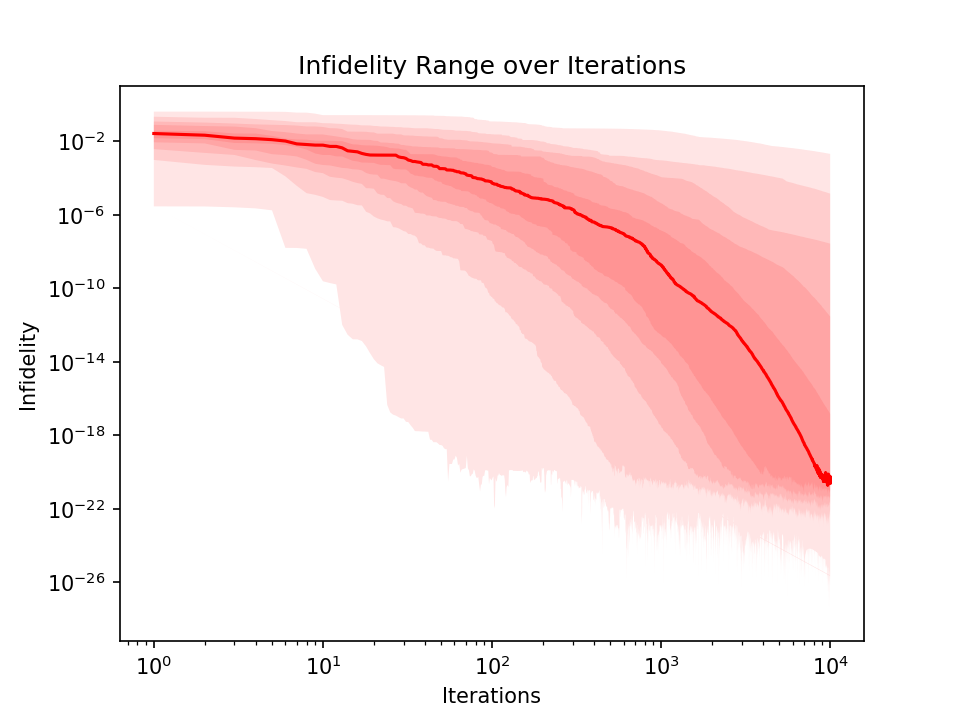

Text(0.5,1,'Infidelity Range over Iterations')

In [271]:
plt.close()
sorted_data = np.sort(err,0)

med = sorted_data[50*n_sim//100,:]
up = sorted_data[75*n_sim//100,:]
down = sorted_data[25*n_sim//100,:]

xaxis = np.arange(1,iters+1)

plt.loglog(xaxis,med,color='r')

for i in range(5):
    plt.fill_between(xaxis, 
                     sorted_data[(99 - i*10)*n_sim//100,:], 
                     sorted_data[(i*10)*n_sim//100,:], 
                     facecolor='r', alpha=0.1)
plt.xlabel("Iterations")
plt.ylabel("Infidelity")
plt.title("Infidelity Range over Iterations")